In [23]:
import tensorflow as tf
import numpy as np
import re
import itertools
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Create a stream of words, then skipgram pairs, then training batches based on the input file.
These streams are built on-demand (see: Python generators) so the whole file does not have to be read into memory at once, allowing training on big datasets.

In [2]:
def word_stream(file_name, buf_bytes=1000000):
    with open(file_name, "r") as f:
        chars = f.read(buf_bytes)
        max_index = 1
        while max_index != 0:
            max_index = 0
            for match in re.finditer("([a-z]+)\\s", chars):
                yield match.group(1)
                max_index = match.end(0)
            chars = chars[max_index:] + f.read(buf_bytes)
        if re.match("[a-z]+", chars):
            yield chars

In [3]:
def vocabulary_statistics(word_stream):
    words = sorted(list(set(word_stream)))
    stats = {}
    for i, w in enumerate(words):
        stats[i] = w
        stats[w] = i
    return stats

In [4]:
def int_stream(word_stream, stats):
    for w in word_stream:
        yield stats[w]

In [5]:
def skipgram_pair_stream(stream, window_size):
    buffer = list(itertools.islice(stream, window_size + 1))
    pointer = 0
    while pointer < len(buffer):
        for i in range(-window_size, window_size + 1):
            other = pointer + i
            if other < 0 or other >= len(buffer) or other == pointer:
                continue
            yield (buffer[pointer], buffer[other])
        # append next of stream to head of buffer (if available)
        try:
            buffer.append(next(stream))
        except StopIteration:
            pass
        # move center point to the head
        pointer += 1
        # remove from tail if no longer needed
        if pointer > window_size:
            buffer.pop(0)
            pointer -= 1

In [6]:
def training_batch_stream(skipgram_stream, batch_size, cache_size=100000):
    cache = list(itertools.islice(skipgram_stream, cache_size))
    while True:
        for i in range(0, len(cache) - batch_size + 1, batch_size):
            block = cache[i:i + batch_size]
            inputs = [pair[0] for pair in block]
            targets = [pair[1] for pair in block]
            yield (inputs, targets)
        cache = cache[len(cache) - (len(cache) % batch_size):]
        new_elements = list(itertools.islice(skipgram_stream, cache_size))
        cache += new_elements
        if len(new_elements) == 0:
            break
    if len(cache) > 0:
        inputs = [pair[0] for pair in cache]
        targets = [pair[1] for pair in cache]
        yield (inputs, targets)

In [7]:
def build_training_stream(text_file_name, stats, window_size, batch_size):
    w_stream = word_stream(text_file_name)
    i_stream = int_stream(w_stream, stats)
    sgp_stream = skipgram_pair_stream(i_stream, window_size)
    batch_stream = training_batch_stream(sgp_stream, batch_size)
    return batch_stream

Build the TensorFlow execution graph for the neural network. The network is fed a list (batch) of input classes and a list of target classes (in the form of 1d vectors of word indices). The result is a 1d vector of the loss for each input.

In [8]:
def build_network(vocab_size, embedding_size, num_samples):
    tf.reset_default_graph()
    
    # input and target output are passed into the network via these placeholders and feed_dict
    inputs_placeholder = tf.placeholder(shape=(None, ), dtype=tf.int32)
    targets_placeholder = tf.placeholder(shape=(None, ), dtype=tf.int32)
    
    weights_initializer = tf.random_uniform_initializer(minval=-0.05, maxval=0.05)
    # weights of input -> hidden (embeddings matrix)
    weights_1 = tf.get_variable("weights_1", shape=(vocab_size, embedding_size),
                                dtype=tf.float32, initializer=weights_initializer)
    # weights of hidden -> output
    weights_2 = tf.get_variable("weights_2", shape=(embedding_size, vocab_size),
                                dtype=tf.float32, initializer=weights_initializer)
    
    # Network input is a 1d vector of word indices
    # convert to a 2d matrix of 1-hot vectors
    net_inputs = tf.one_hot(inputs_placeholder, depth=vocab_size)
    # multiply with embedding matrix
    net_mul1 = tf.matmul(net_inputs, weights_1)
    
    # use sampled softmax loss (number of samples specified)
    if num_samples is not None:
        zero_bias = tf.zeros(vocab_size, dtype=tf.float32)
        targets_reshaped = tf.reshape(targets_placeholder, [-1, 1])
        w2_transposed = tf.transpose(weights_2)
        loss = tf.nn.sampled_softmax_loss(inputs=net_mul1, weights=w2_transposed, biases=zero_bias,
                                          labels=targets_reshaped, num_sampled=num_samples, 
                                          num_classes=vocab_size)
    # use regular softmax loss (no number of samples specified)
    else:
        net_output = tf.matmul(net_mul1, weights_2)
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets_placeholder,
                                                              logits=net_output)
    
    # return only what is necessary
    # input and target placeholders are for feeding data
    # loss is connected to an optimizer which works its way back to the weights to adjust them
    # weights_1 is the embedding matrix containing the word embeddings
    return (inputs_placeholder, targets_placeholder, loss, weights_1)

In [9]:
def train_network(inputs_placeholder, targets_placeholder, weights_1, loss,
                  train_stream_builder, epochs, learning_rate, total_pairs):
    print("training started")
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            batch_count, pairs_count, sum_loss = 0, 0, 0.0
            for batch_inputs, batch_targets in train_stream_builder():
                feed_dict = {inputs_placeholder: batch_inputs, targets_placeholder: batch_targets}
                time_start = time.time()
                sess.run(optimizer, feed_dict=feed_dict)
                time_end = time.time()
                batch_count += 1
                pairs_count += len(batch_inputs)
                batch_loss = sess.run(tf.reduce_mean(loss), feed_dict=feed_dict)
                sum_loss += batch_loss
                if batch_count % 100 == 0:
                    status_info = "{}/{} pairs, avg loss: {:.5f}, time per batch: {:.5f}s"
                    status_info = status_info.format(pairs_count, total_pairs,
                                                     sum_loss / float(batch_count),
                                                     time_end - time_start)
                    print(status_info)
        print("training complete")
        return sess.run(weights_1)

In [10]:
def plot_embeddings(words, embeddings_matrix, dot_size=1):
    tsne = TSNE(n_components=2, random_state=1)
    embeddings_matrix_2d = tsne.fit_transform(embeddings_matrix)
    %matplotlib notebook
    plt.scatter(embeddings_matrix_2d[:,0], embeddings_matrix_2d[:,1], s=dot_size)
    for i, word in enumerate(words):
        plt.text(embeddings_matrix_2d[i][0], embeddings_matrix_2d[i][1], word)
    plt.show()

In [30]:
def parse_term(s):
    term = []
    for m in re.finditer("(\\+|-)?(\\w+)", s):
        word, symbol = m.group(2), m.group(1)
        if symbol is None or symbol == "+":
            factor = 1
        elif symbol == "-":
            factor = -1
        else:
            raise ValueError("invalid symbol")
        term.append((word, factor))
    return term

In [28]:
def embedding_sum(words, embeddings_matrix, term):
    vector = np.zeros(len(embeddings_matrix[0]), dtype=np.float32)
    for word, factor in term:
        vector += embeddings_matrix[words.index(word)] * factor
    return vector

In [37]:
def cosine_similarities(words, embeddings_matrix, vector):
    similarities = []
    for i, word in enumerate(words):
        embedding = embeddings_matrix[i]
        similarity = embedding.dot(vector) / (np.linalg.norm(embedding) * np.linalg.norm(vector))
        similarities.append((word, similarity))
    return sorted(similarities, key = lambda s : -s[1])

In [39]:
def cosine_similarities_s(words, embeddings_matrix, s):
    term = parse_term(s)
    term_words = [t[0] for t in term]
    vector = embedding_sum(words, embeddings_matrix, term)
    similarities = cosine_similarities(words, embeddings_matrix, vector)
    similarities = [s for s in similarities if s[0] not in term_words]
    return similarities

In [49]:
text_file_name = "text8_dropped_short"
window_size = 5
batch_size = 1000
embedding_size = 128
num_samples = None
epochs = 1
learning_rate = 0.02

In [12]:
stats = vocabulary_statistics(word_stream(text_file_name))
words = sorted(list(set(word_stream(text_file_name))))
train_pairs_estimated = sum(2 * window_size for w in word_stream(text_file_name))
train_stream_builder = lambda : build_training_stream(text_file_name, stats, window_size, batch_size)
vocab_size = len(words)
print("vocab size: ", vocab_size)
network = build_network(vocab_size, embedding_size, num_samples)
inputs_placeholder, targets_placeholder, loss, weights_1 = network

vocab size:  975


In [50]:
embeddings_matrix = train_network(inputs_placeholder, targets_placeholder, weights_1,
                                  loss, train_stream_builder, epochs, learning_rate,
                                  train_pairs_estimated)

training started
100000/2305590 pairs, avg loss: 4.96080, time per batch: 0.03346s
200000/2305590 pairs, avg loss: 4.83332, time per batch: 0.03120s
300000/2305590 pairs, avg loss: 4.77174, time per batch: 0.03081s
400000/2305590 pairs, avg loss: 4.72079, time per batch: 0.03099s
500000/2305590 pairs, avg loss: 4.65966, time per batch: 0.03332s
600000/2305590 pairs, avg loss: 4.65025, time per batch: 0.03450s
700000/2305590 pairs, avg loss: 4.64119, time per batch: 0.03453s
800000/2305590 pairs, avg loss: 4.62703, time per batch: 0.03521s
900000/2305590 pairs, avg loss: 4.62628, time per batch: 0.03368s
1000000/2305590 pairs, avg loss: 4.62966, time per batch: 0.03207s
1100000/2305590 pairs, avg loss: 4.61175, time per batch: 0.03410s
1200000/2305590 pairs, avg loss: 4.59243, time per batch: 0.03023s
1300000/2305590 pairs, avg loss: 4.58286, time per batch: 0.03320s
1400000/2305590 pairs, avg loss: 4.57284, time per batch: 0.03031s
1500000/2305590 pairs, avg loss: 4.57174, time per bat

<IPython.core.display.Javascript object>


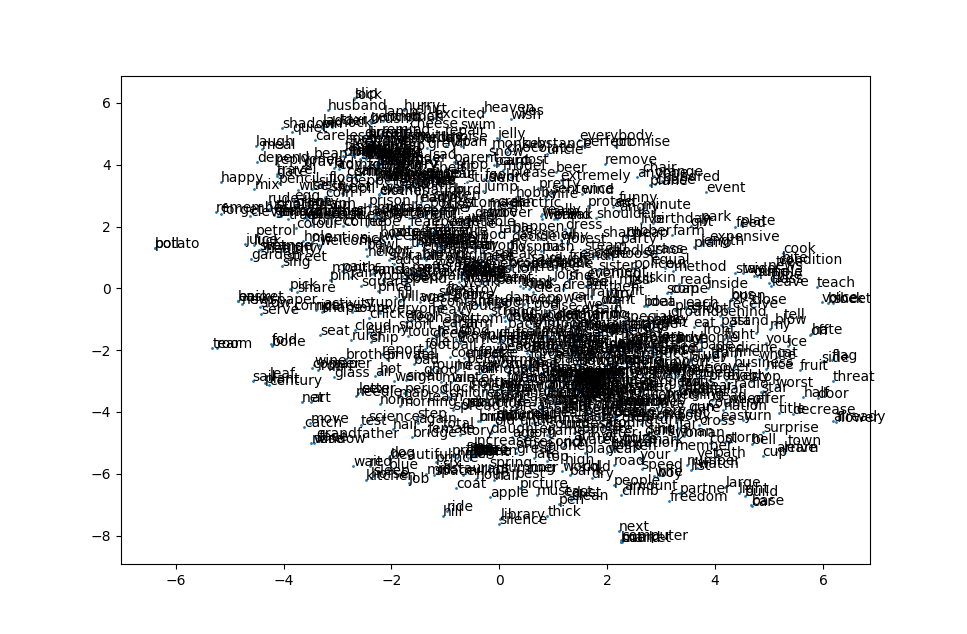

In [52]:
plot_embeddings(words, embeddings_matrix)

In [51]:
print(cosine_similarities_s(words, embeddings_matrix, "man")[:5])
print(cosine_similarities_s(words, embeddings_matrix, "king-man+woman")[:5])

[('woman', 0.5100761), ('from', 0.43719077), ('after', 0.42979088), ('a', 0.419599), ('he', 0.39911965)]
[('repeat', 0.37973508), ('choose', 0.36549556), ('correct', 0.35911945), ('fever', 0.34717664), ('letter', 0.32917568)]
